# Agent-Based Kinetics via Topology (ABa-KiTo)
Date: 09.11.2025

In this notebook I run clustering analysis with different size of intervals and seed to check the clustering of simulation when h is a linear function

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial.distance import pdist
import pickle
import json
import pandas as pd
from datetime import datetime


import sys
import os
import torch as pt
from tqdm import tqdm

import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("NumPy version:", np.__version__)
print("Torch version:", pt.__version__)


NumPy version: 1.26.4
Torch version: 2.3.0+cpu


In [3]:
# Get the absolute path of the parent directory (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..','..','..'))

# Add it to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)

# Now import necessary functions
from src.modules_mokito import *

In [5]:
#Load data formatted from ABM simulations and ISOKANN.jl 

sims_path = os.path.join('ABa-KiTo', 'majority_rule', 'data', 'simulations','')
data_dir =  os.path.join(project_root, sims_path)

# Read data
states_data = np.load(data_dir + '2025-11-18-data_majority_rule.npz')
xs = states_data['xs'] #xs.shape (n_dim, n_samples)
ys = states_data['ys'] #ys-shape (n_dim, n_koop = 1, n_samples)

#Reshape data to use it for MoKiTo
X0 = xs.T #(n_samples, n_dim)
Xt = np.transpose(ys, (2, 1, 0))   # (n_samples, 1, n_dim)

# --- Log + Scale both X0 and Xt consistently ---
scaler = StandardScaler()

# X0
X0_log = np.log1p(X0)
X0_scaled = scaler.fit_transform(X0_log)   # (n_samples, n_dim)

# Xt: flatten for scaling
Xt_flat = Xt.reshape(-1, Xt.shape[2])      # (n_samples * n_koop, n_dim)
Xt_log = np.log1p(Xt_flat)
Xt_scaled = scaler.transform(Xt_log)
Xt_scaled = Xt_scaled.reshape(Xt.shape)    # (n_samples, 1, n_dim)


# # # --- Load chi function ---
chivals_path = os.path.join('ABa-KiTo', 'majority_rule','data',  'chi_vals', '')
chivals_dir = os.path.join(project_root, chivals_path)
chi0 = np.load(chivals_dir + 'chi_values_MR.npz')

# --- Organize for MoKiTo ---
data = OrganizeData(X0_scaled, Xt_scaled, chi0)





Check shape of input data
X0.shape   =  (200000, 202)
Xt.shape   =  (200000, 1, 202)
chi0.shape =  (200000,)
  


In [6]:
intervals = 4
FIs    =  FindIntervals(data, Nintervals=intervals, clustering = 'kmeans')

print("Interval sizes:", FIs.size_intervals)

Computing geometric interval densities...
unormalized density: [0.78811735 0.72390002 0.32966581 0.23173277]
Density estimates: min=0.440, median=1.000, max=1.496
d_low (25th percentile)=0.579, d_high (75th percentile)=1.405
Interval sizes: [117103  58471  17354   7072]



χ-function interval distribution:
chi0 range: [-0.003, 1.026]
chi0 mean: 0.209, std: 0.163
  Interval 0: 117103 points ( 58.6%), χ ∈ [-0.003, 0.181]
  Interval 1:  58471 points ( 29.2%), χ ∈ [0.181, 0.331]
  Interval 2:  17354 points (  8.7%), χ ∈ [0.331, 0.649]
  Interval 3:   7072 points (  3.5%), χ ∈ [0.649, 1.026]


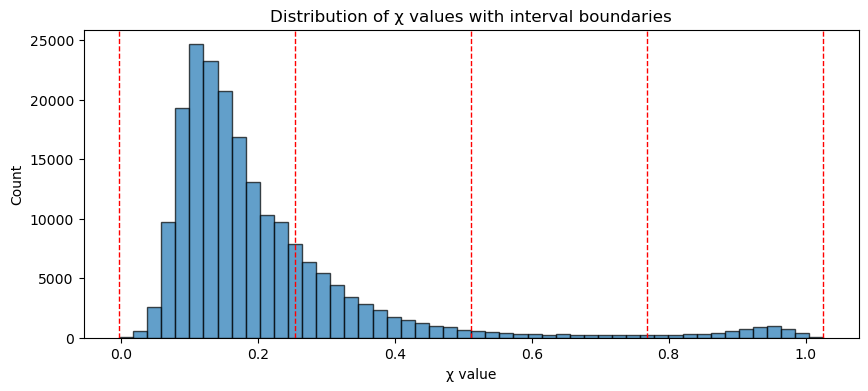

In [7]:
print("\nχ-function interval distribution:")
print(f"chi0 range: [{data.chi0.min():.3f}, {data.chi0.max():.3f}]")
print(f"chi0 mean: {data.chi0.mean():.3f}, std: {data.chi0.std():.3f}")

chi_bins = []  # list to store (min, max) tuples

for i in range(FIs.Nintervals):
    interval_points = FIs.size_intervals[i] if i < len(FIs.size_intervals) else 0
    chi_vals = data.chi0[FIs.chi_intervals == i]

    if len(chi_vals) > 0:
        chi_min, chi_max = chi_vals.min(), chi_vals.max()
        chi_bins.append((chi_min, chi_max))
        print(f"  Interval {i}: {interval_points:6d} points ({interval_points/len(data.chi0)*100:5.1f}%), "
              f"χ ∈ [{chi_min:.3f}, {chi_max:.3f}]")
    else:
        chi_bins.append((None, None))  # placeholder for empty interval
        print(f"  Interval {i}: {interval_points:6d} points (empty)")

# Visualize distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.hist(data.chi0, bins=50, edgecolor='black', alpha=0.7)
intervals = intervals
for edge in np.linspace(data.chi0.min(), data.chi0.max(), intervals + 1):
    plt.axvline(edge, color='red', linestyle='--', linewidth=1)
plt.xlabel('χ value')
plt.ylabel('Count')
plt.title('Distribution of χ values with interval boundaries')
plt.show()

Text(0.5, 1.0, 'Macro variables colored by χ value')

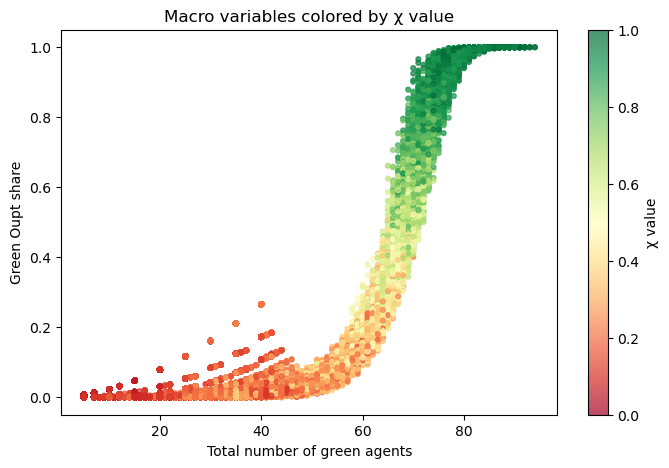

In [8]:
#Scatter plot of macro variables colored by chi interval for practical interpretation of ISOKANN output
# Example data
import matplotlib.colors as mcolors

macro = X0[:, -2:]
chi_intervals = FIs.chi_intervals  # values: 0, 1, 2

macro1 = "Total number of green agents"
macro2 = "Green Oupt share"

labels = [f"[{low:.1f}, {high:.1f}]" for low, high in chi_bins]

#color map
#cmap=plt.cm.viridis
cmap=plt.cm.RdYlGn


# Plot
plt.figure(figsize=(8,5))
sc = plt.scatter(macro[:,0], macro[:,1],
                 c=chi0, #chi_values, 
                 cmap=cmap,
                 s=12, alpha=0.7,
                 vmin=0, vmax=1       # ensure colors go from 0 to 1
                 )

# Add colorbar legend
cbar = plt.colorbar(sc)
cbar.set_label("χ value")


plt.xlabel(macro1)
plt.ylabel(macro2)
plt.title("Macro variables colored by χ value")
#plt.show()

# results_dir = os.path.join('graph_results', 'h_linear')
# os.makedirs(results_dir, exist_ok=True)
# plt.savefig(f"{results_dir}/macro_vars_colored_by_chi_vals.png")

In [13]:
# Create results directory
# Create the path and ensure the directory exists for saving the data
clustering_dir = os.path.join( "..", 'data', 'clustering_results')
os.makedirs(clustering_dir, exist_ok=True)

# Run stability analysis
stability_results = []
intervals =[3,4]
seeds = [42, 123, 456]

for i, Nintervals in enumerate(intervals):
    for seed in seeds:
        print(f"\n{'='*60}")
        print(f"Running: Nintervals={Nintervals}, seed={seed}")
        print(f"{'='*60}")
        
        # Run pipeline
        FCs = FindIntervals(data, Nintervals=Nintervals, 
                            clustering='kmeans', random_state=seed)
        FNs = FindNodes(data, FCs, algorithm='HDBSCAN', random_state=seed)
        
        # Calculate statistics
        chi_means = []
        cluster_sizes = []
        interval_assignments = []
        
        for node_id in range(FNs.Nnodes):
            mask = FNs.nodes == node_id
            chi_means.append(np.mean(data.chi0[mask]))
            cluster_sizes.append(np.sum(mask))
            interval_assignments.append(FNs.index_chi_node[node_id])
        
        chi_means = np.array(chi_means)
        cluster_sizes = np.array(cluster_sizes)
        interval_assignments = np.array(interval_assignments)
        
        # Classify into meta estable states (adjust thresholds based on your data)
        n_brown = np.sum(chi_means < 0.25)
        n_transition = np.sum((chi_means >= 0.25) & (chi_means < 0.55))
        n_green = np.sum(chi_means >= 0.55)
        
        # Store results
        result = {
            'Nintervals': Nintervals,
            'seed': seed,
            'n_clusters': FNs.Nnodes,
            'noise_count': np.sum(FNs.nodes == -1),
            'noise_pct': 100 * np.sum(FNs.nodes == -1) / data.N,
            'n_brown': n_brown,
            'n_transition': n_transition,
            'n_green': n_green,
            'chi_min': float(chi_means.min()),
            'chi_max': float(chi_means.max()),
            'chi_mean': float(chi_means.mean()),
            'chi_std': float(chi_means.std()),
            'clusters_per_interval': FNs.index_chi_node.tolist() if hasattr(FNs.index_chi_node, 'tolist') else list(np.bincount(FNs.index_chi_node)),
            'mean_cluster_size': float(cluster_sizes.mean()),
            'median_cluster_size': float(np.median(cluster_sizes)),
            'max_cluster_size': int(cluster_sizes.max()),
            'min_cluster_size': int(cluster_sizes.min()),
            # Detailed per-cluster info
            'chi_per_cluster': chi_means.tolist(),
            'size_per_cluster': cluster_sizes.tolist(),
            'interval_per_cluster': interval_assignments.tolist(),
        }
        
        stability_results.append(result)
        
        # Save individual run (in case of crashes)
        run_name = f"Nint{Nintervals}_seed{seed}"
        
        # Save as pickle (preserves all Python objects)
        with open(f'{clustering_dir}/{run_name}_FNs.pkl', 'wb') as f:
            pickle.dump(FNs, f)
        
        with open(f'{clustering_dir}/{run_name}_FCs.pkl', 'wb') as f:
            pickle.dump(FCs, f)
        
        print(f"\nSummary:")
        print(f"  Total clusters: {FNs.Nnodes}")
        print(f"  Noise: {result['noise_pct']:.1f}%")
        print(f"  Basins: Brown={n_brown}, Transition={n_transition}, Green={n_green}")
        print(f"  Chi range: [{result['chi_min']:.3f}, {result['chi_max']:.3f}]")

# Save all results as JSON (human-readable)
# with open('stability_results/all_results.json', 'w') as f:
#     json.dump(stability_results, f, indent=2)

# Save as DataFrame for easy analysis
df = pd.DataFrame(stability_results)
df.to_csv(f'{clustering_dir}/summary.csv', index=False)
print(f"\n{'='*60}")
print("All results saved to clustering_dir/")
print(f"{'='*60}")


Running: Nintervals=3, seed=42
Computing geometric interval densities...
unormalized density: [0.78816701 0.54083287 0.23392929]
Density estimates: min=0.433, median=1.000, max=1.457
d_low (25th percentile)=0.716, d_high (75th percentile)=1.229


Processing intervals:  33%|███▎      | 1/3 [1:02:09<2:04:18, 3729.43s/it]

Interval 0: size=141628, density=1.457, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 10427 noise (7.4%), reassigned=92.0%


Processing intervals:  67%|██████▋   | 2/3 [1:10:15<30:21, 1821.71s/it]  

Interval 1: size=50264, density=1.000, min_cluster=45, min_samples=7, eps=1.05, method=eom → 2 clusters, 3989 noise (7.9%), reassigned=92.0%


Processing intervals: 100%|██████████| 3/3 [1:10:30<00:00, 1410.03s/it]

Interval 2: size=8108, density=0.433, min_cluster=47, min_samples=7, eps=1.10, method=leaf → 3 clusters, 635 noise (7.8%), reassigned=92.0%

Summary:
  Total clusters: 7
  Noise: 7.5%
  Basins: Brown=2, Transition=2, Green=3
  Chi range: [0.134, 0.861]

Running: Nintervals=3, seed=123


Computing geometric interval densities...
unormalized density: [0.78816626 0.53280184 0.23393777]
Density estimates: min=0.439, median=1.000, max=1.479
d_low (25th percentile)=0.720, d_high (75th percentile)=1.240


Processing intervals:  33%|███▎      | 1/3 [1:03:44<2:07:28, 3824.45s/it]

Interval 0: size=141764, density=1.479, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 10437 noise (7.4%), reassigned=92.0%


Processing intervals:  67%|██████▋   | 2/3 [1:11:47<30:58, 1858.92s/it]  

Interval 1: size=50138, density=1.000, min_cluster=45, min_samples=7, eps=1.05, method=eom → 2 clusters, 3980 noise (7.9%), reassigned=92.0%


Processing intervals: 100%|██████████| 3/3 [1:12:01<00:00, 1440.63s/it]

Interval 2: size=8098, density=0.439, min_cluster=47, min_samples=7, eps=1.10, method=leaf → 3 clusters, 634 noise (7.8%), reassigned=92.0%

Summary:
  Total clusters: 7
  Noise: 7.5%
  Basins: Brown=2, Transition=2, Green=3
  Chi range: [0.134, 0.861]

Running: Nintervals=3, seed=456


Computing geometric interval densities...
unormalized density: [0.78811627 0.53970383 0.23386983]
Density estimates: min=0.433, median=1.000, max=1.460
d_low (25th percentile)=0.717, d_high (75th percentile)=1.230


Processing intervals:  33%|███▎      | 1/3 [1:02:39<2:05:18, 3759.26s/it]

Interval 0: size=141802, density=1.460, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 10440 noise (7.4%), reassigned=92.0%


Processing intervals:  67%|██████▋   | 2/3 [1:10:56<30:40, 1840.36s/it]  

Interval 1: size=50103, density=1.000, min_cluster=45, min_samples=7, eps=1.05, method=eom → 2 clusters, 3977 noise (7.9%), reassigned=92.0%


Processing intervals: 100%|██████████| 3/3 [1:11:10<00:00, 1423.63s/it]

Interval 2: size=8095, density=0.433, min_cluster=47, min_samples=7, eps=1.10, method=leaf → 3 clusters, 634 noise (7.8%), reassigned=92.0%

Summary:
  Total clusters: 7
  Noise: 7.5%
  Basins: Brown=2, Transition=2, Green=3
  Chi range: [0.134, 0.861]

Running: Nintervals=4, seed=42


Computing geometric interval densities...
unormalized density: [0.7880889  0.71676366 0.34586815 0.23179559]
Density estimates: min=0.436, median=1.000, max=1.483
d_low (25th percentile)=0.597, d_high (75th percentile)=1.383


Processing intervals:  25%|██▌       | 1/4 [40:06<2:00:20, 2406.73s/it]

Interval 0: size=116306, density=1.483, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 8555 noise (7.4%), reassigned=92.0%


Processing intervals:  50%|█████     | 2/4 [51:28<46:24, 1392.27s/it]  

Interval 1: size=58968, density=1.349, min_cluster=47, min_samples=7, eps=1.00, method=eom → 2 clusters, 4574 noise (7.8%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals:  75%|███████▌  | 3/4 [53:33<13:33, 813.49s/it] 

Interval 2: size=17635, density=0.651, min_cluster=37, min_samples=5, eps=1.32, method=leaf (fallback) → 0 clusters, 17635 noise (100.0%), reassigned=0.0%


Processing intervals: 100%|██████████| 4/4 [53:44<00:00, 806.20s/it]

Interval 3: size=7091, density=0.436, min_cluster=47, min_samples=7, eps=1.10, method=leaf → 5 clusters, 546 noise (7.7%), reassigned=92.0%

Summary:
  Total clusters: 9
  Noise: 15.7%
  Basins: Brown=3, Transition=1, Green=5
  Chi range: [0.122, 0.885]

Running: Nintervals=4, seed=123


Computing geometric interval densities...
unormalized density: [0.78807229 0.71470858 0.3318488  0.23164305]
Density estimates: min=0.443, median=1.000, max=1.506
d_low (25th percentile)=0.586, d_high (75th percentile)=1.401


Processing intervals:  25%|██▌       | 1/4 [42:07<2:06:22, 2527.33s/it]

Interval 0: size=117148, density=1.506, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 8618 noise (7.4%), reassigned=92.0%


Processing intervals:  50%|█████     | 2/4 [52:54<47:22, 1421.19s/it]  

Interval 1: size=58633, density=1.366, min_cluster=46, min_samples=7, eps=1.00, method=eom → 2 clusters, 4550 noise (7.8%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals:  75%|███████▌  | 3/4 [54:57<13:48, 828.58s/it] 

Interval 2: size=17170, density=0.634, min_cluster=37, min_samples=5, eps=1.32, method=leaf (fallback) → 0 clusters, 17170 noise (100.0%), reassigned=0.0%


Processing intervals: 100%|██████████| 4/4 [55:09<00:00, 827.34s/it]

Interval 3: size=7049, density=0.443, min_cluster=47, min_samples=7, eps=1.10, method=leaf → 5 clusters, 543 noise (7.7%), reassigned=92.0%

Summary:
  Total clusters: 9
  Noise: 15.4%
  Basins: Brown=3, Transition=1, Green=5
  Chi range: [0.122, 0.888]

Running: Nintervals=4, seed=456


Computing geometric interval densities...
unormalized density: [0.78811046 0.73341873 0.32964891 0.23181931]
Density estimates: min=0.436, median=1.000, max=1.483
d_low (25th percentile)=0.574, d_high (75th percentile)=1.406


Processing intervals:  25%|██▌       | 1/4 [37:12<1:51:37, 2232.42s/it]

Interval 0: size=114969, density=1.483, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 8456 noise (7.4%), reassigned=92.0%


Processing intervals:  50%|█████     | 2/4 [47:11<42:22, 1271.49s/it]  

Interval 1: size=59728, density=1.380, min_cluster=47, min_samples=7, eps=1.00, method=eom → 2 clusters, 4630 noise (7.8%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals:  75%|███████▌  | 3/4 [49:08<12:24, 744.47s/it] 

Interval 2: size=18155, density=0.620, min_cluster=37, min_samples=5, eps=1.32, method=leaf (fallback) → 0 clusters, 18155 noise (100.0%), reassigned=0.0%


Processing intervals: 100%|██████████| 4/4 [49:18<00:00, 739.66s/it]

Interval 3: size=7148, density=0.436, min_cluster=47, min_samples=7, eps=1.10, method=leaf → 4 clusters, 555 noise (7.8%), reassigned=92.0%

Summary:
  Total clusters: 8
  Noise: 15.9%
  Basins: Brown=3, Transition=1, Green=4
  Chi range: [0.121, 0.885]

All results saved to clustering_dir/



=== STABILITY ANALYSIS SUMMARY ===

Overall Statistics:
  Total runs: 6
  Clusters per run: 7.8 ± 1.0
  Noise percentage: 11.6% ± 4.5%

Basin Structure (average across runs):
  Brown clusters: 2.5 ± 0.5
  Transition clusters: 1.5 ± 0.5
  Green clusters: 3.8 ± 1.0

Chi Value Ranges:
  Min chi: 0.128 ± 0.007
  Max chi: 0.873 ± 0.014


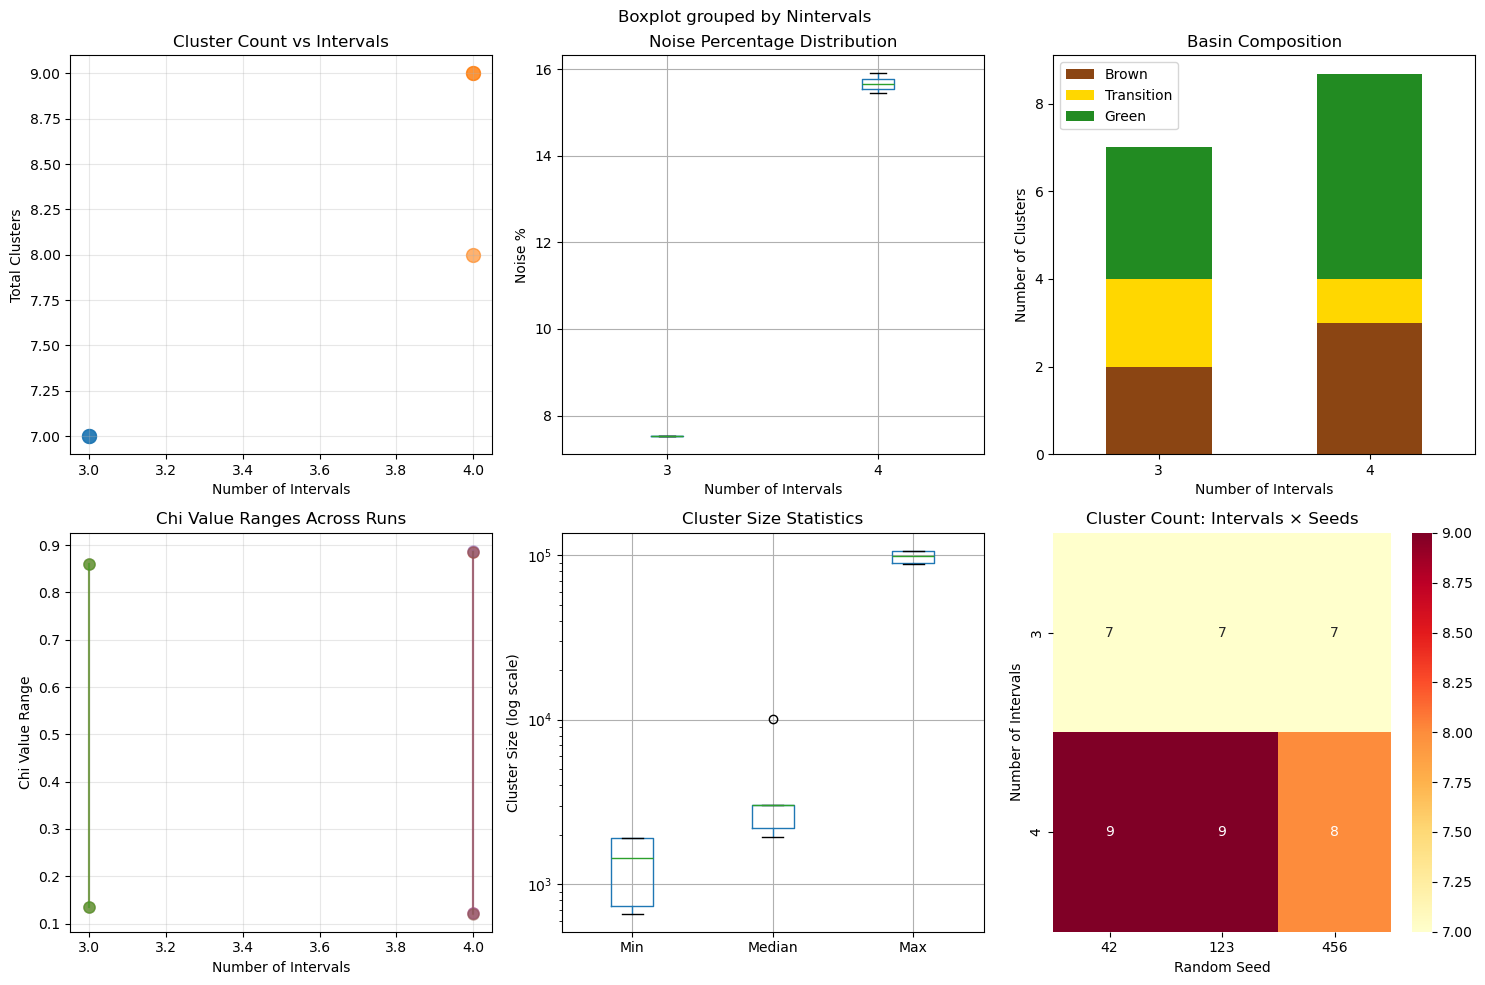


Figure saved to stability_results01/stability_analysis.png


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load results
df = pd.read_csv(f'{clustering_dir}/summary.csv')

# Create summary statistics
print("\n=== STABILITY ANALYSIS SUMMARY ===\n")
print("Overall Statistics:")
print(f"  Total runs: {len(df)}")
print(f"  Clusters per run: {df['n_clusters'].mean():.1f} ± {df['n_clusters'].std():.1f}")
print(f"  Noise percentage: {df['noise_pct'].mean():.1f}% ± {df['noise_pct'].std():.1f}%")
print(f"\nBasin Structure (average across runs):")
print(f"  Brown clusters: {df['n_brown'].mean():.1f} ± {df['n_brown'].std():.1f}")
print(f"  Transition clusters: {df['n_transition'].mean():.1f} ± {df['n_transition'].std():.1f}")
print(f"  Green clusters: {df['n_green'].mean():.1f} ± {df['n_green'].std():.1f}")
print(f"\nChi Value Ranges:")
print(f"  Min chi: {df['chi_min'].mean():.3f} ± {df['chi_min'].std():.3f}")
print(f"  Max chi: {df['chi_max'].mean():.3f} ± {df['chi_max'].std():.3f}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Number of clusters vs parameters
ax = axes[0, 0]
for Nint in intervals:
    subset = df[df['Nintervals'] == Nint]
    ax.scatter([Nint]*len(subset), subset['n_clusters'], 
               s=100, alpha=0.6, label=f'N={Nint}')
ax.set_xlabel('Number of Intervals')
ax.set_ylabel('Total Clusters')
ax.set_title('Cluster Count vs Intervals')
ax.grid(True, alpha=0.3)

# 2. Noise percentage
ax = axes[0, 1]
df.boxplot(column='noise_pct', by='Nintervals', ax=ax)
ax.set_xlabel('Number of Intervals')
ax.set_ylabel('Noise %')
ax.set_title('Noise Percentage Distribution')
plt.sca(ax)
plt.xticks([1, 2], intervals)

# 3. Basin composition
ax = axes[0, 2]
basin_means = df.groupby('Nintervals')[['n_brown', 'n_transition', 'n_green']].mean()
basin_means.plot(kind='bar', stacked=True, ax=ax, 
                 color=['#8B4513', '#FFD700', '#228B22'])
ax.set_xlabel('Number of Intervals')
ax.set_ylabel('Number of Clusters')
ax.set_title('Basin Composition')
ax.legend(['Brown', 'Transition', 'Green'])
ax.set_xticklabels([3,4], rotation=0)

# 4. Chi range stability
ax = axes[1, 0]
for idx, row in df.iterrows():
    ax.plot([row['Nintervals']]*2, [row['chi_min'], row['chi_max']], 
            'o-', alpha=0.5, markersize=8)
ax.set_xlabel('Number of Intervals')
ax.set_ylabel('Chi Value Range')
ax.set_title('Chi Value Ranges Across Runs')
ax.grid(True, alpha=0.3)

# 5. Cluster size distribution
ax = axes[1, 1]
df.boxplot(column=['min_cluster_size', 'median_cluster_size', 'max_cluster_size'], 
           ax=ax)
ax.set_ylabel('Cluster Size (log scale)')
ax.set_yscale('log')
ax.set_title('Cluster Size Statistics')
ax.set_xticklabels(['Min', 'Median', 'Max'], rotation=0)

# 6. Reproducibility heatmap
ax = axes[1, 2]
pivot = df.pivot_table(values='n_clusters', 
                       index='Nintervals', 
                       columns='seed', 
                       aggfunc='first')
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax)
ax.set_title('Cluster Count: Intervals × Seeds')
ax.set_xlabel('Random Seed')
ax.set_ylabel('Number of Intervals')

plt.tight_layout()
#plt.savefig('stability_results01/stability_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure saved to stability_results01/stability_analysis.png")

In [15]:
# Simple stability checks
print("\n=== STABILITY CHECKS ===\n")

# Check 1: Does 3-basin structure always appear?
all_have_basins = all((df['n_brown'] > 0) & 
                      (df['n_transition'] > 0) & 
                      (df['n_green'] > 0))
print(f"✓ All runs show 3-basin structure: {all_have_basins}")

# Check 2: Are chi ranges consistent?
chi_range_cv = df['chi_min'].std() / df['chi_min'].mean()
print(f"✓ Chi minimum coefficient of variation: {chi_range_cv:.2%}")
print(f"  (< 10% = very stable, < 20% = stable, > 20% = variable)")

# Check 3: Is noise percentage reasonable?
noise_stable = df['noise_pct'].std() < 5.0  # Less than 5% variation
print(f"✓ Noise percentage stable (σ < 5%): {noise_stable}")
print(f"  Mean: {df['noise_pct'].mean():.1f}%, Std: {df['noise_pct'].std():.1f}%")

# Check 4: Does structure scale predictably with Nintervals?
corr = df[['Nintervals', 'n_clusters']].corr().iloc[0, 1]
print(f"✓ Clusters scale with intervals (correlation): {corr:.2f}")
print(f"  (> 0.8 = predictable scaling)")





=== STABILITY CHECKS ===

✓ All runs show 3-basin structure: True
✓ Chi minimum coefficient of variation: 5.45%
  (< 10% = very stable, < 20% = stable, > 20% = variable)
✓ Noise percentage stable (σ < 5%): True
  Mean: 11.6%, Std: 4.5%
✓ Clusters scale with intervals (correlation): 0.93
  (> 0.8 = predictable scaling)


In [16]:
import pandas as pd
import json

# Load results
df = pd.read_csv(f'{clustering_dir}/summary.csv')

print("\n=== DETAILED DIAGNOSTICS ===\n")

# Find runs missing basins
print("Runs missing basins:")
for idx, row in df.iterrows():
    missing = []
    if row['n_brown'] == 0:
        missing.append('BROWN')
    if row['n_transition'] == 0:
        missing.append('TRANSITION')
    if row['n_green'] == 0:
        missing.append('GREEN')
    
    if missing:
        print(f"  Nint={row['Nintervals']}, seed={row['seed']}: Missing {', '.join(missing)}")
        print(f"    → {row['n_clusters']} clusters, {row['noise_pct']:.1f}% noise")
        print(f"    → Chi range: [{row['chi_min']:.3f}, {row['chi_max']:.3f}]")

# Find high-noise runs
print("\nHigh noise runs (>15%):")
high_noise = df[df['noise_pct'] > 15]
for idx, row in high_noise.iterrows():
    print(f"  Nint={row['Nintervals']}, seed={row['seed']}: {row['noise_pct']:.1f}% noise")
    print(f"    → Basins: B={row['n_brown']}, T={row['n_transition']}, G={row['n_green']}")

# Show variation by Nintervals
print("\nStatistics by Nintervals:")
print(df.groupby('Nintervals')[['n_clusters', 'noise_pct', 'n_brown', 'n_transition', 'n_green']].agg(['mean', 'std']))


=== DETAILED DIAGNOSTICS ===

Runs missing basins:

High noise runs (>15%):
  Nint=4, seed=42: 15.7% noise
    → Basins: B=3, T=1, G=5
  Nint=4, seed=123: 15.4% noise
    → Basins: B=3, T=1, G=5
  Nint=4, seed=456: 15.9% noise
    → Basins: B=3, T=1, G=4

Statistics by Nintervals:
           n_clusters          noise_pct           n_brown      n_transition  \
                 mean      std      mean       std    mean  std         mean   
Nintervals                                                                     
3            7.000000  0.00000    7.5255  0.000000     2.0  0.0          2.0   
4            8.666667  0.57735   15.6645  0.228898     3.0  0.0          1.0   

                  n_green           
            std      mean      std  
Nintervals                          
3           0.0  3.000000  0.00000  
4           0.0  4.666667  0.57735  
